# Choice of portfolio

## Aim of project and underlying assumptions:

The aim of this project is to find the combination of the following stocks, that contains the lowest risk:

- AeroVironment, Inc. (AVAV)
- Ferrari N.V. (RACE)
- Las Vegas Sands (LVS)
- Tesla Motors (TSLA)

To find the portfolio that carry the minimum risk, we take an offset in Modern Portfolio Theory, finding the portfolio combination that bears the lowest risk i.e. the Minimum Variance Portolio (MVP). To do this we import data from Yahoo Finance and simulate all possible portfolios using Monte Carlo simulation. From our Monte Carlo simulation we will be able to allocate the portfolio that carries the lowest risk and find the efficient frontier - without the possibility of leverage investments nor investing in the risk free market.

In our model we make the following assumptions: 

1. <i>Investors can buy and sell all securities at competitive market prices and can borrow and lend at the risk-free interest rate</i>
2. <i>Investors hold only efficient portfolios of traded securities</i>
3. <i>Investors have homogenous expectations</i>

> <i>Source: Berk & DeMarzo, 2014</i>

Lastly we assume 253 trading days a year, and look at data from january 1st 2010 untill january 1st 2020 to make our estimations. Therfore our results will be showing the optimal portfolio per January 1st 2020. 

As an extention to the project we introduce the possibility to lend and borrow in the risk free market. This allow us to make use of the Capital Asset Pricing Model (CAPM), which ultimately gives us the portfolio with the optimal ratio between expected return and risk i.e where we maximze the sharpe-ratio.  




In [1]:
# Imported packages
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.stats as scs
import scipy.optimize as sco
import statsmodels.api as sm
import scipy.interpolate as sci
from pandas_datareader import data as pdr
import yfinance as yf

First we get all the data into the file, and use the dividend-adjusted closing prices as the closing price for a given stock.

In [2]:
# Time period and stocks: 
start_date = datetime.datetime(2010,1,1)
end_date = datetime.datetime(2020,1,1)
stocks = ["AVAV", "RACE","LVS","TSLA"]
num_stocks = len(stocks)


# Get data as dataframe:
yf.pdr_override() 
data = pdr.get_data_yahoo(stocks, start=start_date, end=end_date)["Adj Close"]
data.iloc[np.r_[0:2, -2:0]]

# Get risk free rate
risk_free_rate = pdr.get_data_yahoo("^TNX",start='2020-01-01',end='2020-01-01')["Adj Close"]
print(risk_free_rate)
data.head()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed
Date
2019-12-31    1.919
Name: Adj Close, dtype: float64


,AVAV,LVS,RACE,TSLA
Date,,,,
2009-12-31,29.080000,9.963785,NaN,NaN
2010-01-04,29.610001,11.084208,NaN,NaN
2010-01-05,29.000000,12.184628,NaN,NaN
2010-01-06,28.590000,12.071250,NaN,NaN
2010-01-07,28.719999,12.338018,NaN,NaN


Secondly we calculate daily returns as:

$$
R_d = Ln \Big(\frac{P_t}{P_{t-1}} \Big)
$$

Where $R_d$ is dayily return. <br>

We take the natural logarithm to measure returns correctly.

In [3]:
# Calculate log daily returns

log_daily_return = np.log(data / data.shift(1))
log_daily_return.iloc[np.r_[0:2, -2:0]]


,AVAV,LVS,RACE,TSLA
Date,,,,
2009-12-31,NaN,NaN,NaN,NaN
2010-01-04,0.018062,0.106564,NaN,NaN
2019-12-30,0.011696,-0.006329,-0.020479,-0.037113
2019-12-31,-0.016704,-0.003759,0.001451,0.008715



Below is the logged daily returns for each shock shown in a simple plot

C:\Users\soebe\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Daily returns')

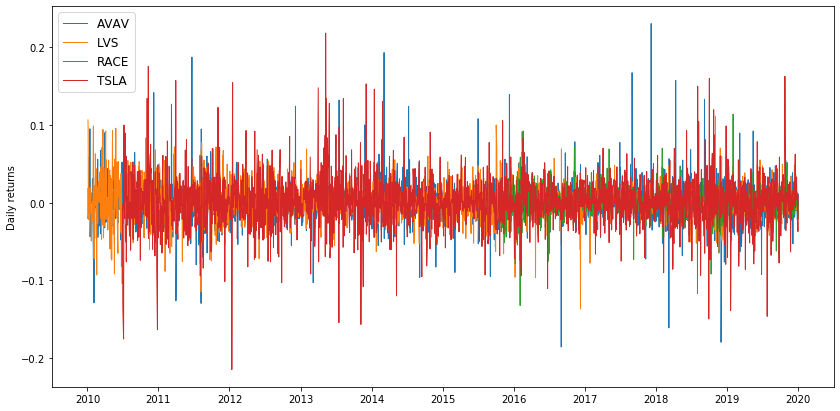

In [4]:
# plot log_daily_returns

plt.figure(figsize=(14, 7))
for c in log_daily_return.columns.values:
    plt.plot(log_daily_return.index, log_daily_return[c],lw=1, alpha=1, label=c)
plt.legend(fontsize=12)
plt.ylabel('Daily returns')

Now we plot cumulative returns, which shows us the performance of each individuals stock from 2010 to 2020. 

Text(0, 0.5, 'Cumulative return, in %')

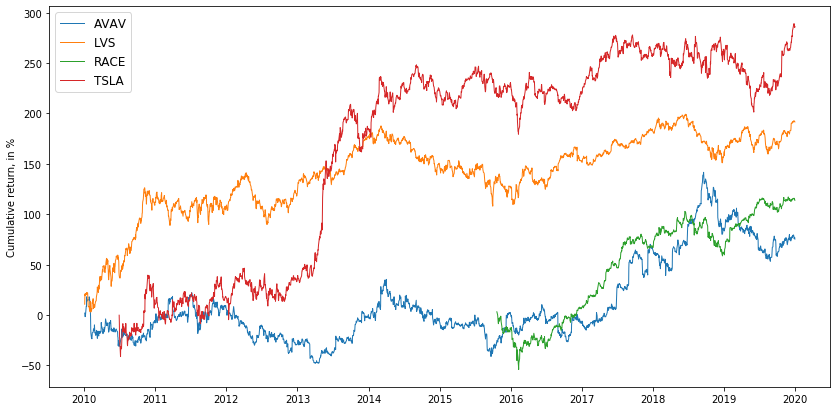

In [5]:
Performance = log_daily_return.cumsum() * 100
Performance.iloc[np.r_[0:2, -2:0]]


plt.figure(figsize=(14, 7))
for x in log_daily_return.columns.values:
    plt.plot(log_daily_return.index, Performance[x], lw=1, alpha=1, label=x)
plt.legend(fontsize=12)
plt.ylabel('Cumulative return, in %')

To find the expected returns and their corresponding variances, we calculate average annualized return for an asset, <i>i</i>:<br>


$$
\bar{R_i} = \frac{1}{T} \sum_{i=1}^T R_d \times d \hspace{10mm} \\ 
$$
<br>
Where <i>T</i> is days and d is average annual trading days


In [6]:
yearly_trading_days = 253

# Mean returns, YoY

AY_return = log_daily_return.mean() * yearly_trading_days
Avg_yearly_return = pd.DataFrame()
Avg_yearly_return["Avg. annual return"] = AY_return 
Avg_yearly_return["Avg. annual return"] = pd.Series(["{0:.2f}%".format(val*100) for val in Avg_yearly_return['Avg. annual return']],index = Avg_yearly_return.index)
Avg_yearly_return

,Avg. annual return
AVAV,7.57%
LVS,19.27%
RACE,27.33%
TSLA,30.27%


Based on our annual returns, we create a covariance matrix showing how each stock covariate meaning how one stocks react to a change of the price of another stock.

Covariance betwteen asset, <i>i</i> and asset, <i>j</i> from historical data is calculated as:
$$
Cov(R_i,R_j) = \frac{1}{T-1} {\sum}_t (R_{i,t} - \bar{R_i})(R_{j,t}- \bar{R_j})
$$

In [7]:
CovMatrix = log_daily_return.cov() * yearly_trading_days
CovMatrix

,AVAV,LVS,RACE,TSLA
AVAV,0.161158,0.031635,0.023854,0.035864
LVS,0.031635,0.126548,0.030966,0.044943
RACE,0.023854,0.030966,0.087751,0.037584
TSLA,0.035864,0.044943,0.037584,0.263141


In order to perform the Monte Carlo Simulation, the weights of the risky assets, $x_i$, must equal 1 for any given portfolio combination. Every weight for each stock is randomized in every portfolio simulation. 

Hence, portfolio returns is calculated as:<br>

$$
R_p = x_1 R_1 + x_2 R_2 +\text{...}+ x_n R_n = {\sum}_i x_i R_i
$$ <br>


Finally the standard deviation (volatity) is calculated as:

$$
SD(R_p) = \sqrt{Var(R_p)} = \frac{1}{n} {\sum}^n_{i=1} (R_i - \bar{R_i})^2
$$

Now we can procceed to the Monte Carlo Simulation.

# Monte Carlo Simulation

In our Monte Carlo Simulation we randomize 10.000 different portfolio combinations using the above explained calculations for return and standard deviation. Then we create two numpy arrays with the simulated porfolio returns and volatility.

In [8]:
%%time
portfolio_return = [] 
portfolio_stdv = [] 

for p in range (10000):
 

 weights = np.random.random(num_stocks)
 weights /= np.sum(weights)
 
 portfolio_return.append(np.sum(log_daily_return.mean() * weights) * yearly_trading_days)

 portfolio_stdv.append(np.sqrt(np.dot(weights.T, np.dot(log_daily_return.cov() * yearly_trading_days, weights))))


portfolio_return = np.array(portfolio_return)
portfolio_stdv = np.array(portfolio_stdv)


Wall time: 35.2 s


All possible portfolio choices are plotted below.

Text(0, 0.5, 'Expected Return of Portfolio')

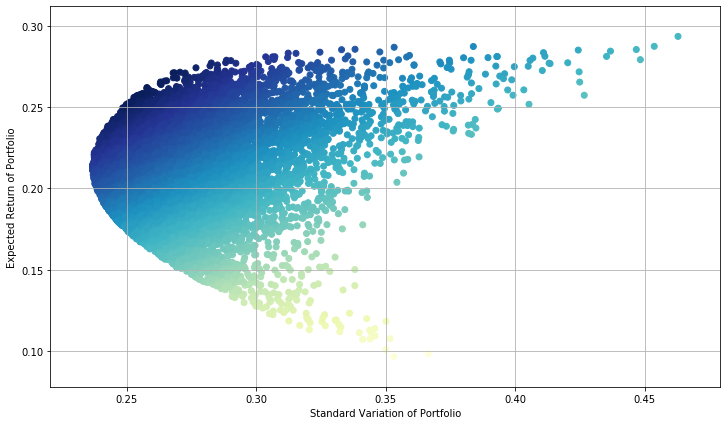

In [9]:
plt.figure(figsize=(12, 7))
plt.scatter(portfolio_stdv, portfolio_return, c = portfolio_return / portfolio_stdv, marker='o', cmap='YlGnBu')

plt.grid(True)
plt.xlabel('Standard Variation of Portfolio')
plt.ylabel('Expected Return of Portfolio')

# Calculating the minimum variance portfolio & efficiency frontier

In order to calculate the minimum variance portfolio, we set up our calculations similiar to the ones used in the Monte Carlo Simulation. 

In [10]:
def portfolio(weights):
 weights = np.array(weights)
 portfolio_return = np.sum(log_daily_return.mean() * weights) * yearly_trading_days # Portfolio annualized return
 portfolio_stdv = np.sqrt(np.dot(weights.T, np.dot(log_daily_return.cov() * yearly_trading_days, weights))) # Portfolio annualized standard deviation
 return np.array([portfolio_return, portfolio_stdv, portfolio_return / portfolio_stdv]) # Portfolio annualized return, Portfolio annualized standard deviation, Portfolio Sharpe ratio
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
#this is a dictionary with two objects which constrains the optimization
bnds = tuple((0, 1) for x in range(num_stocks))

Once the minimum variance portfolio, we calcuate it as: <br>

$$
\textit{Min} \hspace{1mm} SD(R_p) \hspace{5mm} \text{s.t.} \hspace{5mm} Cov(R_i,R_j)^{-1} \times 1,\hspace{1mm} w_i = 1
$$

The minimization problem is calculated below.

In [11]:
def min_func_variance(weights):
     return portfolio(weights)[1] ** 2 # portfolio variance

In [12]:
%%time
opt_variance = sco.minimize(min_func_variance, num_stocks * [1. / num_stocks,], method='SLSQP', bounds=bnds,
constraints=cons)

Wall time: 207 ms


The weights of the minimum variance portfolio is found by printing the minimization problem: 

In [13]:
opt_variance

     fun: 0.05608348189367983
     jac: array([0.11195554, 0.11222531, 0.1121587 , 0.11261478])
 message: 'Optimization terminated successfully.'
    nfev: 48
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.21308404, 0.25041807, 0.4600344 , 0.07646348])

From the print, the 'x' is considered the portfolio weights. The weights of the minimum variance portfolio is: 

In [53]:
Min_var_weights = opt_variance['x'].round(3)
Minimum_Variance_Portfolio = pd.DataFrame([Min_var_weights])
Minimum_Variance_Portfolio.columns = [stocks]
Minimum_Variance_Portfolio

,AVAV,RACE,LVS,TSLA
0,0.213,0.25,0.46,0.076


The efficient frontier is found as the optimal portfolio at a given level of risk. This frontier contains a set of the most diversified portfolios possible with the given set of stocks. <br>

The problem can be expressed as: <br>

$$
\textit{min } \hspace{2mm} \lambda * w^T \sum w - (1-\lambda)*w^T \mu \\
\text{s.t. } \hspace{2mm} {\sum}_i w_i = 1 
$$

where $\lambda$ is the weighting parameter.


In [28]:
def min_func_port(weights):
     return portfolio(weights)[1] # portfolio function

In [29]:

cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - target_return},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
# normal bounds for optimization

In [30]:

target_returns = np.linspace(0.1, 0.3, 50) # target return, within 10 % to 30 %, 50 samples
target_stdv = []
for target_return in target_returns:
 cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - target_return}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
 res = sco.minimize(min_func_port, num_stocks * [1. / num_stocks,], method='SLSQP', bounds=bnds, constraints=cons)
 target_stdv.append(res['fun'])
target_stdv = np.array(target_stdv)

We now plot the minimum variance portfolio and the efficient frontier into our previous. 

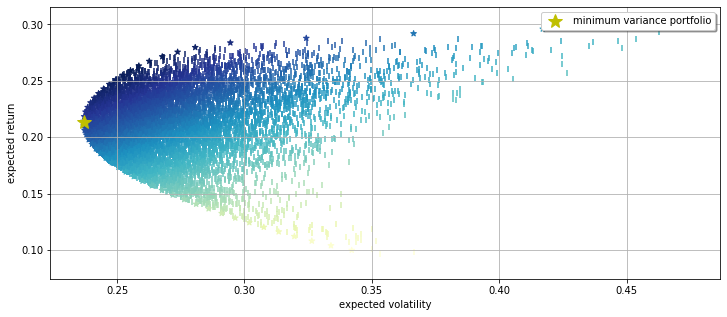

In [31]:
plt.figure(figsize=(12, 5))
plt.scatter(portfolio_stdv, portfolio_return,
 c=portfolio_return / portfolio_stdv, marker='|', cmap ='YlGnBu')
 # random portfolio composition
plt.scatter(target_stdv, target_returns,
 c=target_returns / target_stdv, marker='*', cmap='YlGnBu')
 # efficient frontier

plt.plot(portfolio(opt_variance['x'])[1], portfolio(opt_variance['x'])[0],
 'y*', markersize=15.0,label ='minimum variance portfolio')
 # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.legend(loc='upper right', shadow=True, ncol=1)

# Capital market line 

The Capital Market Line gives us all the possible combinations of our optimal portfolio and the risk-free investment. This line is the investor's opportunity to design a portfolio that suits their desire of risk and still hold the portfolio that maximizes return relative to risk. If we, for example, have an extremely risk-averse investor, then the person would purely hold the risk-free asset. On the other hand, if we see a risk-loving investor, then it will be possible to borrow at the risk-free rate and buy the optimal portfolio (i.e., where we have the highest Sharpe-Ratio), and achieve a higher expected return on the cost of bearing a higher level of risk.

First we define the efficient standard deviation and return, and find our efficient frontier once again. 

In [32]:
ind = np.argmin(target_stdv) # index number of portfolio 
efficient_stdv = target_stdv[ind:] # indexed portfolios volatility
efficient_returns = target_returns[ind:] # indexed portolfios return

In [33]:
tck = sci.splrep(efficient_stdv, efficient_returns) # Cubic splines interpolation based
                               # on the indexed portfolios' values of
                               # return and volatility

In [34]:
def f(x):
#Efficient frontier function (splines approximation)
 return sci.splev(x, tck, der=0)
def df(x):
#First derivative of efficient frontier function
 return sci.splev(x, tck, der=1)

To further find the risk-adjusted optimized portfolio, the CAPM function must be applied. CAPM is expressed as: 
$$
E R_i = R_f + \beta_i (E R_m - R_f)
$$

Where: <br>
<br>
$E R_i =$ Expected return of investment <br>
$R_f =$ risk-free rate <br>
$\beta_i =$ beta of the investment <br>
$E R_m - R_f =$ market risk premium <br>
<br>
CAPM is defined below.

In [46]:
def equations(z, rf):
    eq1 = rf - z[0]  
    eq2 = rf + z[1] * z[2] - f(z[2])
    eq3 = z[1] - df(z[2])
    return eq1, eq2, eq3

def riskfree(rf):
    return(sco.fsolve(equations, [0.01, 0.5, 0.15], rf))

The optimized risk-adjusted portfolio will be defined by optimizing the sharpe ratio. <br>
The sharpe ratio is expressed as: <br>
<br>

$$
\text{Sharpe Ratio =} \hspace{2mm} \frac{\text{Portfolio Excess Return}}{\text{Portfolio Volatility}} = \frac{E[R_p] - r_f}{SD(R_p)} = S(p)
$$

Sharpe is included below to find the optimized risk-adjusted portfolio with a given risk-free rate. 

In [47]:
def CAPM_FIGURE(rf, portfolio_stdv=portfolio_stdv, portfolio_return=portfolio_return , p=p ):
    plt.figure(figsize=(16, 8))
    plt.scatter(portfolio_stdv, portfolio_return,
    c=(portfolio_return - rf) / portfolio_stdv, marker='o', cmap='YlGnBu')
    # random portfolio composition
    plt.plot(efficient_stdv, efficient_returns, 'black', lw=3.0)
    # efficient frontier
    cx = np.linspace(0.0, 0.3)
    temp = riskfree(rf)  #making a temp, so it doesnt have to calculate riskfree over and over. 
    plt.plot(cx, temp[0] + temp[1] * cx, lw=2.0)
    # capital market line
    plt.plot(temp[2], f(temp[2]), 'r*', markersize=15.0)
    plt.grid(True)
    plt.axhline(0, color='k', ls='-', lw=2.0)
    plt.axvline(0, color='k', ls='-', lw=2.0)
    plt.ylim(-0.1 , 0.35)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
    plt.colorbar(label='Sharpe ratio')
    plt.show()

Now we plot the Capital Market line, that gives us the optimal portfolio assuming that we can borrow and lend at the same rate. We will always choose to invest in the portfolio that maximizes the sharpe-ratio, and then gear up or down to match the desired level of risk. 

Below is the CAPM figure plotted with an interest rate of 3%.

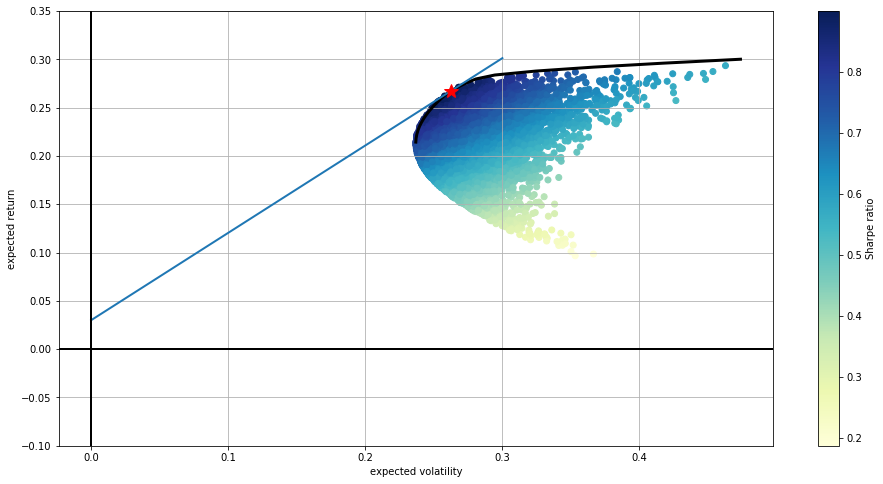

In [48]:
CAPM_FIGURE(0.03)

Finally an interactive plot is created with the posibility to adjust the risk free rate, which directly change the Capital Market Lines intersection with the y-axis and the Sharpe Ratio, which also depends on the risk free return. We see that the optimal portfolio changes with changes in the interest rate.

In [49]:
widgets.interact(CAPM_FIGURE,
                 rf = widgets.FloatSlider(description="Risk Free rate", min=-0.1, max=0.1, step=0.01, value=0),
                 portfolio_stdv = widgets.fixed(portfolio_stdv),
                 portfolio_return=widgets.fixed(portfolio_return),
                 p=widgets.fixed(p)
                );



interactive(children=(FloatSlider(value=0.0, description='Risk Free rate', max=0.1, min=-0.1, step=0.01), Outp…

# Final Remarks

In this project, we have found the optimal portfolio being the allocation of the red star in the above plot. We started by collecting data from Yahoo Finance. Then we made a Monte Carlo Simulation on 10.000 plots to give a representative picture of all possible portfolio combinations of our analyzed stocks. 
 Then we found the efficient frontier, which tells us what portfolios that bears the lowest risk for a given expected return. Thirdly we found the Minimum Variance Portfolio and the portfolio that contained the highest Sharpe-Ratio to create our Capital Market Line.